Start with our usual setup, including the utility methods from last time.

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Make matplotlib figures appear inline in the
# notebook rather than in a new window
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def display(img, title=None):
    # Show image
    plt.figure(figsize = (5,5))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

Optional: we'll use the OpenCV library's convolution function, which is much faster. You may need to run `pip3 install opencv-python` and restart Jupyter notebook.

In [53]:
import cv2

We'll start by reviewing the example from lecture: the iguana and the horizontal derivative.

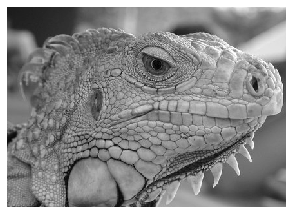

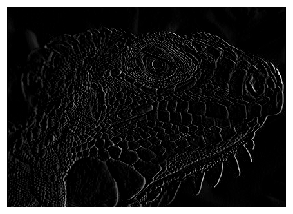

In [54]:
image = cv2.imread("./iguana.png", cv2.IMREAD_GRAYSCALE)
display(image)

derivative_filter = np.array(
[
    [1,0,-1]
])

result = cv2.filter2D(image, -1, derivative_filter)
display(result)

# Exercise 1

Let's try and address some of the problems that we found in lecture.

**Sub-problem 1:** The image is dark, and it's hard to tell where the edges are that we found. How can we improve on this? Can we do this in a single filter?

The simplest solution would be to brighten each pixel using the brighten filter:

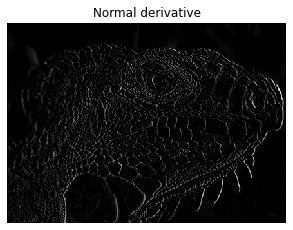

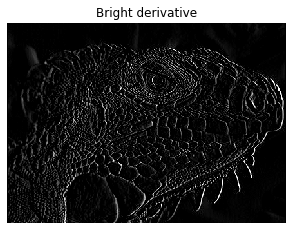

In [55]:
brighten_filter = np.array(
[
    [2.]
])

result_bright = cv2.filter2D(result, -1, brighten_filter)
display(result, "Normal derivative")
display(result_bright, "Bright derivative")

We can combine these sub-passes. If we think about the sequence of filters as the dot product `s(p_1 * f_1 + ... + p_n * f_n)`, we can see that we can distribute the `s` to each `f_n`.

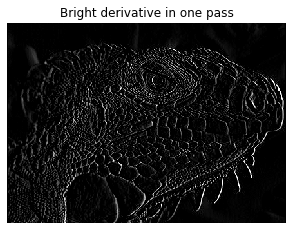

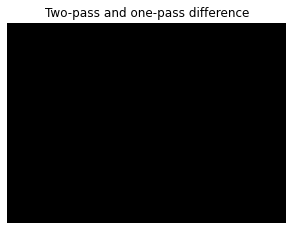

In [56]:
bright_derivative_filter = derivative_filter * 2.

result_bright_2 = cv2.filter2D(image, -1, bright_derivative_filter)
display(result_bright_2, "Bright derivative in one pass")

display(np.abs((result_bright / 255. - result_bright_2 / 255.)), "Two-pass and one-pass difference")

**Sub-problem 2:** The algorithm finds lots of edges, but we don't care about all of them. Could we keep only the brightest edges somehow?

This algorithm works by deciding which pixels are definitely edges (i.e. they pass the high threshold) and deciding which pixels are certainly not edges (i.e. they fail the low threshold) and then repeatedly transforming "gray pixels" (i.e. pixels that passed neither threshold) into definite edges if they are near definite edges. In effect, this algorithm identifies the strongest edges in the image and then applies a "bucket fill" style algorithm to complete the edge from these seed pixels.

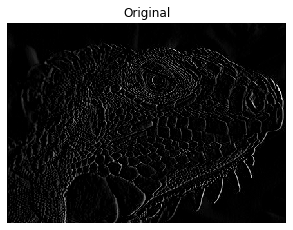

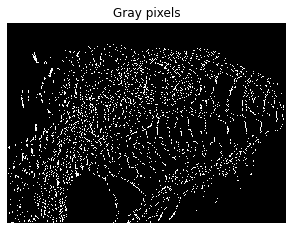

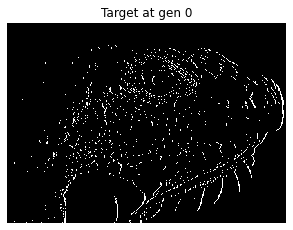

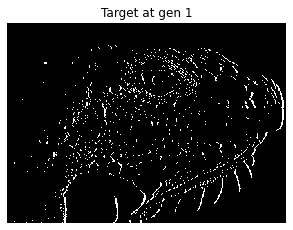

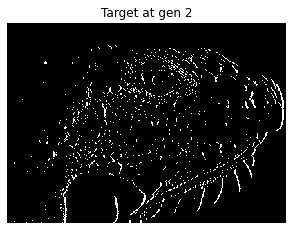

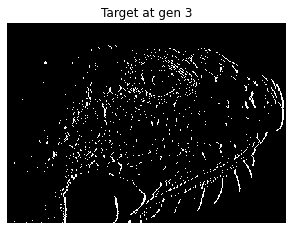

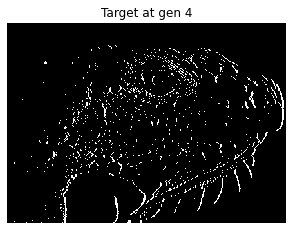

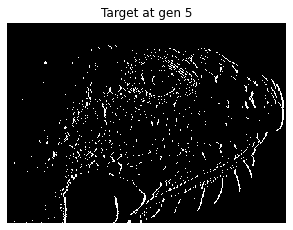

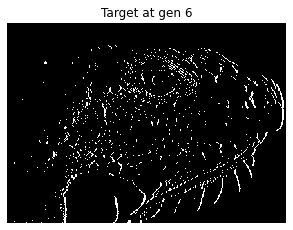

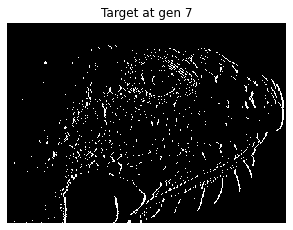

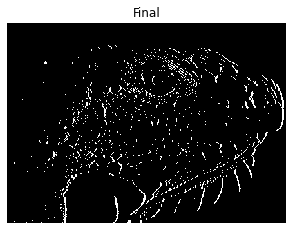

In [57]:
def rgb_u8_to_luma_f32(original):
    target = np.zeros(original.shape[0:2])

    for x, y in np.ndindex(target.shape):
        target[x, y] = float(np.average(original[x, y])) / 255.

    return target

# Ok. Maybe I was a bit too harsh on numpy...
def double_threshold(original, low_threshold, high_threshold, keep_alive_sz, keep_alive_pop, gen):
    # Generate a boolean mask of pixels above the low threshold
    above_low = original > low_threshold

    # Generate a boolean mask of all alive pixels
    target = original > high_threshold

    display(above_low & np.bitwise_not(target), "Gray pixels")

    # Repeat over the specified number of generations
    for i in range(gen):
        display(target, f"Target at gen {i}")

        # Use a square blur to get a population percentage of nearby alive pixels.
        populations = cv2.blur(np.where(target, 1., 0.), (keep_alive_sz, keep_alive_sz))

        # Filter the population counts by the required population.
        # Automatically promote pixels that were already white.
        target = target | (populations > keep_alive_pop)

        # Finally, ensure that only gray and white pixels are ever promoted to white.
        target = target & above_low

    return target

display(result, "Original")
display(double_threshold(
    original=rgb_u8_to_luma_f32(result),
    low_threshold=0.1,
    high_threshold=0.2,
    keep_alive_sz=5,
    keep_alive_pop=0.2,
    gen=8
), "Final")

**Sub-problem 3:** We used a horizontal derivative filter. Create and run a vertical derivative filter. Should it look similar? Does it? Find an image where the horizontal and vertical derivative filters produce very different output.

The vertical derivative should typically look a little different from the horizontal derivative because edges are not always perfectly aligned with one axis. In the worst case scenario, an edge may be perfectly horizontal, meaning that only the vertical derivative may detect it.

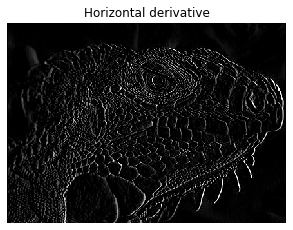

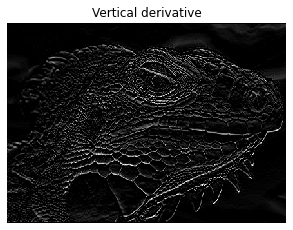

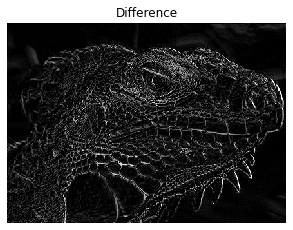

In [58]:
derivative_filter_y = np.array(
[
    [0,  2, 0],
    [0,  0, 0],
    [0, -2, 0],
])

result_bright_y = cv2.filter2D(image, -1, derivative_filter_y)
display(result_bright_2, "Horizontal derivative")
display(result_bright_y, "Vertical derivative")
display(np.abs(result_bright_2 / 255. - result_bright_y / 255.), "Difference")

These two results look visibly different... but not different enough. Behold, the worst case image!

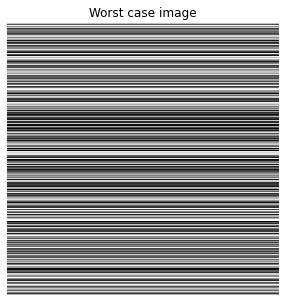

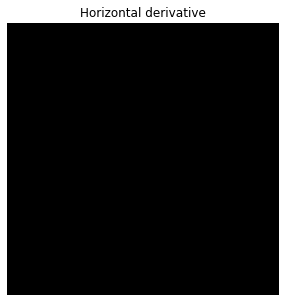

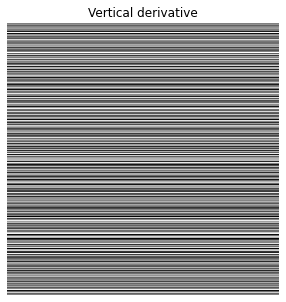

In [59]:
import random

width, height = (500, 500)

def gen_row(_):
    val = random.random()
    return list(map(lambda _: val, range(width)))

bad_image = np.array(list(map(
    gen_row,
    range(height)
)))

bad_bright_x = cv2.filter2D(bad_image, -1, bright_derivative_filter)
bad_bright_y = cv2.filter2D(bad_image, -1, derivative_filter_y)

display(bad_image, "Worst case image")
display(bad_bright_x, "Horizontal derivative")
display(bad_bright_y, "Vertical derivative")

**Sub-problem 4:** How does the derivative filter respond to noise? Load and run the filter on the noisy_einstein image. Can you improve on this result?

Noise is the arch enemy of the derivative filter. Noise typically contrasts with the background a lot, causing the derivative filter to detect it as an edge. We can remove this noise this image by smoothing all edges through a blur filter. In doing so, each edge becomes sort of "spread out" across multiple pixels, dropping the small edges created by the noise. However, this will also have the unfortunate side-effect of reducing the brightness of true edges (something the second filter accounts for by brightening the final result).

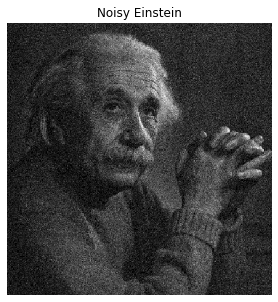

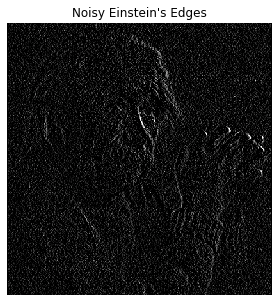

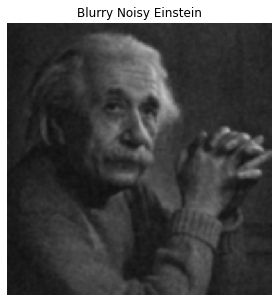

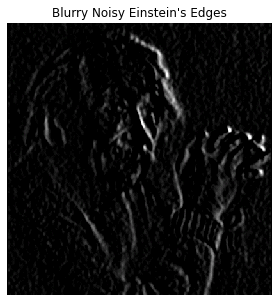

In [60]:
image2 = cv2.imread("noisy_einstein.png")

display(image2, "Noisy Einstein")

image2_result = cv2.filter2D(image2, -1, bright_derivative_filter)
display(image2_result, "Noisy Einstein's Edges")

image2_blur = cv2.GaussianBlur(image2, [0, 0], 2)
display(image2_blur, "Blurry Noisy Einstein")

image2_blur_result = cv2.filter2D(image2_blur, -1, derivative_filter * 7)
display(image2_blur_result, "Blurry Noisy Einstein's Edges")

## Dead Code

Scrapped code I ended up not using.

In [61]:
def swap(target, a, b):
    tmp = target[a]
    target[a] = b
    target[b] = tmp

def swap_remove(target, i):
    swap(target, i, len(target) - 1)
    target.pop()

def double_threshold(image, low_threshold, high_threshold, gray_list = None):
    image = np.copy(image)

    for x, y in np.ndindex(image.shape):
        pixel = image[y, y]
        if pixel < low_threshold:
            image[x, y] = 0
        elif pixel < high_threshold:
            image[x, y] = 0.5
            if gray_list is not None:
                gray_list.append((x, y))
        else:
            image[x, y] = 1

def alive_in_range(image, center, radius):
    count = 0
    for x in range(center[0] - radius, center[0] + radius + 1):
        for y in range(center[1] - radius, center[1] + radius + 1):
            if image[x, y] == 1:
                count += 1
    return count

def non_bright_removal(image, low_threshold, high_threshold, keep_alive_sz, keep_alive_pop):
    # Collect pixels
    gray_queue = []
    target = double_threshold(image, low_threshold, high_threshold, gray_queue)

    # Propagate alive state
    dirty = len(gray_queue) > 0
    while dirty:
        display(target, "Propagate phase")

        dirty = False
        i = 0
        while i < len(gray_queue):
            (px_x, px_y) = gray_queue[i]
            pop = float(alive_in_range(target, (px_x, px_y), keep_alive_sz)) / float((keep_alive_sz * 2 + 1) ** 2)

            if pop > keep_alive_pop:
                target[px_x, px_y] = 1.
                dirty = True
                swap_remove(gray_queue, i)
            else:
                i += 1

    # Condemn remaining pixels
    for pixel in gray_queue:
        target[pixel] = 0

    return target

display(non_bright_removal(image, 0.2, 0.7, 3, 0.25), "Final result")

IndexError: index 310 is out of bounds for axis 0 with size 310